crm.lead.list Total_count = 130
crm.deal.list Total_count = 5
user.get Total_count = 111
crm.status.list Total_count = 238


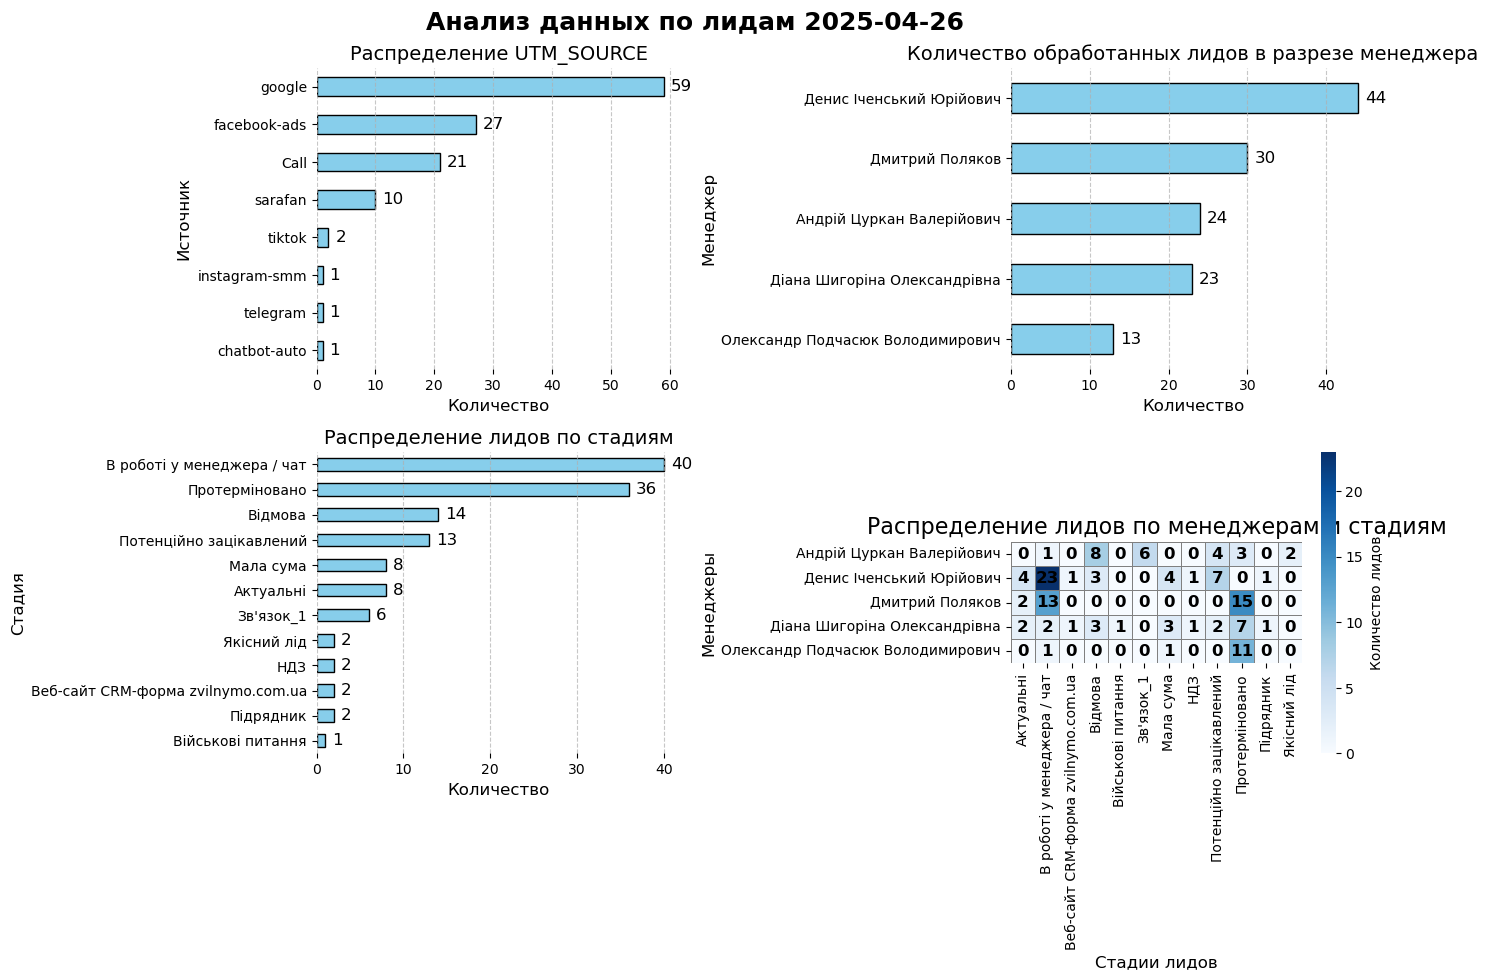

<Figure size 640x480 with 0 Axes>

In [7]:
import requests
from datetime import datetime, timedelta
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from b24 import B24
    

yesterday = (datetime.today() - timedelta(days=1)).strftime('%Y-%m-%d')
#Выгружаем данные по лидам из СRM
b24 = B24('ua.zvilnymo.com.ua', 596, 'l13ymwtftv37nmdq')
leads = b24.get_list('crm.lead.list', b24_filter={'>=DATE_CREATE': f'{yesterday}T00:00:01', '<=DATE_CREATE': f'{yesterday}T23:59:59'}, 
                    select=['ID','STATUS_ID','ASSIGNED_BY_ID','DATE_CREATE','UTM_SOURCE','UF_CRM_1745414446'])
leads_df = pd.DataFrame(leads)

leads_df['DATE_CREATE'] = pd.to_datetime(leads_df['DATE_CREATE'])
leads_df['taken_in_work'] = pd.to_datetime(leads_df['UF_CRM_1745414446'])
leads_df = leads_df.drop('UF_CRM_1745414446', axis=1)

# Вычисляем разницу во времени
leads_df['time_taken_in_work'] = leads_df['taken_in_work'] - leads_df['DATE_CREATE']

#Выгружаем данные по сделкам из СRM
category_id = 0

yesterday = (datetime.today() - timedelta(days=1)).strftime('%Y-%m-%d')

deal_filter = {
    "CATEGORY_ID": category_id, 
    ">=CLOSEDATE": f'{yesterday}T00:00:01',  
    "<=CLOSEDATE": f'{yesterday}T23:59:59',
    'STAGE_ID': 'WON'
}

select_fields = ["ID", "OPPORTUNITY", 'ASSIGNED_BY_ID', 'CLOSEDATE', 'UTM_SOURCE', 'UF_CRM_1695636781']  

deals = b24.get_list("crm.deal.list", b24_filter=deal_filter, select=select_fields)
deals_list = pd.DataFrame(deals)

#Выгружаем данные по менеджерам из СRM
b24 = B24('ua.zvilnymo.com.ua', 596, 'vt8sovzu4o2y28j7')
items_users = b24.get_list('user.get', select=['ID','NAME', 'LAST_NAME', 'SECOND_NAME'])
users_df = pd.DataFrame(items_users)[['ID', 'NAME', 'LAST_NAME', 'SECOND_NAME']]
users_df['FULL_NAME'] = users_df[['NAME', 'LAST_NAME', 'SECOND_NAME']].fillna('').agg(' '.join, axis=1).str.strip()
users_df = users_df[['ID', 'FULL_NAME']]

#Считаю конверсии
agg_leads = leads_df.groupby('ASSIGNED_BY_ID') \
        .agg({'ID':'count','time_taken_in_work':'median'}) \
        .reset_index() \
        .rename(columns={'ID':'number_of_leads'})

agg_deals = deals_list.groupby('ASSIGNED_BY_ID') \
        .agg({'ID':'count'}) \
        .reset_index() \
        .rename(columns={'ID':'number_of_deals'})

full_agg_data = agg_leads.merge(agg_deals,how='left', on='ASSIGNED_BY_ID')

datetime_cols = full_agg_data.select_dtypes(include=['datetime', 'datetimetz']).columns
for col in datetime_cols:
    median_value = full_agg_data[col].dropna().median()
    full_agg_data[col] = full_agg_data[col].fillna(median_value)

# Все остальные (числовые, строковые и т.п.)
other_cols = full_agg_data.columns.difference(datetime_cols)
for col in other_cols:
    if pd.api.types.is_numeric_dtype(full_agg_data[col]):
        full_agg_data[col] = full_agg_data[col].fillna(0)
    else:
        full_agg_data[col] = full_agg_data[col].fillna('0')

full_agg_data['CR%'] = round(full_agg_data.number_of_deals/full_agg_data.number_of_leads,2) * 100
full_agg_data = full_agg_data.merge(users_df, left_on='ASSIGNED_BY_ID', right_on='ID')
full_agg_data = full_agg_data[['CR%','FULL_NAME','time_taken_in_work']]



#Выгружаем данные по стадиям из СRM
b24 = B24('ua.zvilnymo.com.ua', 596, 'hfyrvmf8dqrff3ph')
status_list = b24.get_list('crm.status.list', select=['ID','NAME'])
df_status = pd.DataFrame(status_list)
df_status = df_status[['STATUS_ID','NAME']]


#Объединям данные
leads_by_managers = leads_df.merge(users_df,how='inner', left_on='ASSIGNED_BY_ID', right_on='ID')
full_data = leads_by_managers.merge(df_status,how='inner', left_on='STATUS_ID', right_on='STATUS_ID') \
    .drop_duplicates()[['ID_x','DATE_CREATE','UTM_SOURCE','FULL_NAME','NAME']]
full_data = full_data.rename(columns={'ID_x':'ID_lead','FULL_NAME':'manager_name','NAME':'status_lead'})


# Создаем фигуру с 2 строками и 2 столбцами
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Получаем текущую дату в формате ДД.ММ.ГГГГ
yesterday_date = (datetime.today() - timedelta(days=1)).strftime('%Y-%m-%d')


# Добавляем общий заголовок с датой
fig.suptitle(f'Анализ данных по лидам {yesterday_date}', fontsize=18, fontweight='bold')

# 1-й график: Распределение UTM_SOURCE
full_data.UTM_SOURCE.value_counts(ascending=True).plot(kind='barh', ax=axes[0, 0], color='skyblue', edgecolor='black')
axes[0, 0].set_title('Распределение UTM_SOURCE', fontsize=14)
axes[0, 0].set_xlabel('Количество', fontsize=12)
axes[0, 0].set_ylabel('Источник', fontsize=12)
axes[0, 0].tick_params(axis='y', rotation=0, labelsize=10)  # Уменьшаем размер шрифта
axes[0, 0].grid(axis='x', linestyle='--', alpha=0.7)
for p in axes[0, 0].patches:
    axes[0, 0].annotate(f'{p.get_width():.0f}', 
                       (p.get_width(), p.get_y() + p.get_height() / 2.), 
                       ha='left', va='center', fontsize=12, color='black', 
                       xytext=(5, 0), textcoords='offset points')
for spine in axes[0, 0].spines.values():
    spine.set_visible(False)

# 2-й график: Количество обработанных сделок в разрезе менеджера (горизонтальный)
full_data.manager_name.value_counts(ascending=True).plot(kind='barh', ax=axes[0, 1], color='skyblue', edgecolor='black')
axes[0, 1].set_title('Количество обработанных лидов в разрезе менеджера', fontsize=14)
axes[0, 1].set_xlabel('Количество', fontsize=12)
axes[0, 1].set_ylabel('Менеджер', fontsize=12)
axes[0, 1].tick_params(axis='y', rotation=0, labelsize=10)  # Уменьшаем размер шрифта
axes[0, 1].grid(axis='x', linestyle='--', alpha=0.7)
for p in axes[0, 1].patches:
    axes[0, 1].annotate(f'{p.get_width():.0f}', 
                       (p.get_width(), p.get_y() + p.get_height() / 2.), 
                       ha='left', va='center', fontsize=12, color='black', 
                       xytext=(5, 0), textcoords='offset points')
for spine in axes[0, 1].spines.values():
    spine.set_visible(False)

# 3-й график: Распределение лидов по стадиям (горизонтальный)
full_data.status_lead.value_counts(ascending=True).plot(kind='barh', ax=axes[1, 0], color='skyblue', edgecolor='black')
axes[1, 0].set_title('Распределение лидов по стадиям', fontsize=14)
axes[1, 0].set_xlabel('Количество', fontsize=12)
axes[1, 0].set_ylabel('Стадия', fontsize=12)
axes[1, 0].tick_params(axis='y', rotation=0, labelsize=10)  # Уменьшаем размер шрифта
axes[1, 0].grid(axis='x', linestyle='--', alpha=0.7)
for p in axes[1, 0].patches:
    axes[1, 0].annotate(f'{p.get_width():.0f}', 
                       (p.get_width(), p.get_y() + p.get_height() / 2.), 
                       ha='left', va='center', fontsize=12, color='black', 
                       xytext=(5, 0), textcoords='offset points')
for spine in axes[1, 0].spines.values():
    spine.set_visible(False)

# 4-й график: Heatmap распределения лидов по менеджерам и стадиям
stage_by_manager_data = full_data.pivot_table(index='manager_name', 
                     columns='status_lead', 
                     values='ID_lead',  
                     aggfunc='count',  
                     fill_value=0) 

sns.heatmap(stage_by_manager_data, 
            annot=True,  
            fmt='d',     
            cmap='Blues',  
            cbar_kws={'label': 'Количество лидов'},  
            annot_kws={"size": 12, "weight": 'bold', "color": 'black'},  
            linewidths=0.5,  
            linecolor='gray',  
            square=True, 
            ax=axes[1, 1])  # Применяем heatmap на 4-й подграфик
axes[1, 1].set_title('Распределение лидов по менеджерам и стадиям', fontsize=16)
axes[1, 1].set_xlabel('Стадии лидов', fontsize=12)
axes[1, 1].set_ylabel('Менеджеры', fontsize=12)

for spine in axes[1, 1].spines.values():
    spine.set_visible(False)

# Настройки для компоновки графиков
plt.subplots_adjust(hspace=0.3)  # Увеличиваем расстояние между строками
plt.tight_layout()  # Сжать графики для лучшего отображения
plt.show()

plt.tight_layout()  # Сжать графики для лучшего отображения

# Сохранение изображения через fig.savefig()
fig.savefig('output_image.png', bbox_inches='tight', dpi=300)



#Отправляем данные в телеграм бота

TOKEN = "8024442492:AAEOg60JnXOC4OpIHqwAWeLwptQMrHwHQ3o"

chat_ids = [727013047, 718885452, 6775209607, 1139941966, 332270956]

def send_message(text, chat_ids):
    url = f"https://api.telegram.org/bot{TOKEN}/sendMessage"
    for chat_id in chat_ids:
        requests.post(url, data={"chat_id": chat_id, "text": text, "parse_mode": "HTML"})

def send_graph_to_telegram(image_path, chat_ids):
    url = f"https://api.telegram.org/bot{TOKEN}/sendPhoto"
    for chat_id in chat_ids:
        with open(image_path, "rb") as photo:  # Открываем файл внутри цикла
            requests.post(url, data={"chat_id": chat_id}, files={"photo": photo})
            
# Получаем медиану времени по отделу
median_reaction = leads_df['time_taken_in_work'].median()
median_reaction_str = str(pd.to_timedelta(median_reaction)).split()[-1]
median_reaction_seconds = pd.to_timedelta(median_reaction).total_seconds()

message_text = (
    f"☀️ Доброе утро!\n"
    f"📊 Это отчет за <b>{yesterday_date}</b>.\n"
    f"🚀 Вчера прилетело <b>{leads_df.shape[0]}</b> лидов.\n\n"
    f"🏢 <b>Швидкість реакції по відділу:</b> <b>{median_reaction_str}</b> "
    f"{'⏰' if median_reaction_seconds > 20 * 60 else ''}\n\n"
    f"<b>Конверсии с лида в продажу и время реакции:</b>\n\n" +
    "\n────────────\n".join(
        f"👤 <b>{row['FULL_NAME']}</b>\n"
        f"   CR%: <b>{row['CR%']}%</b> {'🔴' if row['CR%'] < 0.1 else ''}\n"
        f"   Швидкість реакції: <b>{str(pd.to_timedelta(row['time_taken_in_work'])).split()[-1]}</b> "
        f"{'⏰' if pd.to_timedelta(row['time_taken_in_work']).total_seconds() > 20*60 else ''}"
        for _, row in full_agg_data.iterrows()
    )
)




send_graph_to_telegram("C:/Users/Андрей/computer/Desktop/Zvilnymo_analytics/leads_project/output_image.png", chat_ids)
send_message(message_text, chat_ids)

In [16]:
#CR2
round(deals_list.shape[0]/leads_df[leads_df['STATUS_ID']=='CONVERTED'].shape[0]*100,2)

32.69

In [17]:
#CR1
round(leads_df[leads_df['STATUS_ID']=='CONVERTED'].shape[0]/leads_df.shape[0]*100,2)

13.42

In [18]:
import requests
from datetime import datetime, timedelta
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from b24 import B24
    

today = datetime.today()

# День недели сегодня (0 — понедельник, 6 — воскресенье)
weekday = today.weekday()

# Находим понедельник предыдущей недели
start_date = today - timedelta(days=weekday + 7)
# Воскресенье предыдущей недели
end_date = start_date + timedelta(days=6)

# Преобразуем в нужный формат
start_str = start_date.strftime('%Y-%m-%dT00:00:01')
end_str = end_date.strftime('%Y-%m-%dT23:59:59')

#Выгружаем данные по лидам из СRM
b24 = B24('ua.zvilnymo.com.ua', 596, 'l13ymwtftv37nmdq')
leads = b24.get_list('crm.lead.list', b24_filter={'>=DATE_CREATE': f'{start_str}', '<=DATE_CREATE': f'{end_str}'}, 
                    select=['ID','STATUS_ID','ASSIGNED_BY_ID','DATE_CREATE','UTM_SOURCE','UF_CRM_1745414446'])
leads_df = pd.DataFrame(leads)

leads_df['DATE_CREATE'] = pd.to_datetime(leads_df['DATE_CREATE'])
leads_df['taken_in_work'] = pd.to_datetime(leads_df['UF_CRM_1745414446'])
leads_df = leads_df.drop('UF_CRM_1745414446', axis=1)

# Вычисляем разницу во времени
leads_df['time_taken_in_work'] = leads_df['taken_in_work'] - leads_df['DATE_CREATE']

#Выгружаем данные по сделкам из СRM
category_id = 0

deal_filter = {
    "CATEGORY_ID": category_id, 
    ">=CLOSEDATE": f'{start_str}',  
    "<=CLOSEDATE": f'{end_str}',
    'STAGE_ID': 'WON'
}

select_fields = ["ID", "OPPORTUNITY", 'ASSIGNED_BY_ID', 'CLOSEDATE', 'UTM_SOURCE', 'UF_CRM_1695636781']  

deals = b24.get_list("crm.deal.list", b24_filter=deal_filter, select=select_fields)
deals_list = pd.DataFrame(deals)

#Выгружаем данные по менеджерам из СRM
b24 = B24('ua.zvilnymo.com.ua', 596, 'vt8sovzu4o2y28j7')
items_users = b24.get_list('user.get', select=['ID'])
users_df = pd.DataFrame(items_users)[['ID', 'NAME', 'LAST_NAME', 'SECOND_NAME']]
users_df['FULL_NAME'] = users_df[['NAME', 'LAST_NAME', 'SECOND_NAME']].fillna('').agg(' '.join, axis=1).str.strip()
users_df = users_df[['ID', 'FULL_NAME']]

#Считаю конверсии
agg_leads = leads_df.groupby('ASSIGNED_BY_ID') \
        .agg({'ID':'count','time_taken_in_work':'median'}) \
        .reset_index() \
        .rename(columns={'ID':'number_of_leads'})

agg_deals = deals_list.groupby('ASSIGNED_BY_ID') \
        .agg({'ID':'count'}) \
        .reset_index() \
        .rename(columns={'ID':'number_of_deals'})

full_agg_data = agg_leads.merge(agg_deals,how='left', on='ASSIGNED_BY_ID')

datetime_cols = full_agg_data.select_dtypes(include=['datetime', 'datetimetz']).columns
for col in datetime_cols:
    median_value = full_agg_data[col].dropna().median()
    full_agg_data[col] = full_agg_data[col].fillna(median_value)

# Все остальные (числовые, строковые и т.п.)
other_cols = full_agg_data.columns.difference(datetime_cols)
for col in other_cols:
    if pd.api.types.is_numeric_dtype(full_agg_data[col]):
        full_agg_data[col] = full_agg_data[col].fillna(0)
    else:
        full_agg_data[col] = full_agg_data[col].fillna('0')

full_agg_data['CR%'] = round(full_agg_data.number_of_deals/full_agg_data.number_of_leads,2) * 100
full_agg_data = full_agg_data.merge(users_df, left_on='ASSIGNED_BY_ID', right_on='ID')
full_agg_data = full_agg_data[['CR%','FULL_NAME','time_taken_in_work']]



#Выгружаем данные по стадиям из СRM
b24 = B24('ua.zvilnymo.com.ua', 596, 'hfyrvmf8dqrff3ph')
status_list = b24.get_list('crm.status.list', select=['ID','NAME'])
df_status = pd.DataFrame(status_list)
df_status = df_status[['STATUS_ID','NAME']]


#Объединям данные
leads_by_managers = leads_df.merge(users_df,how='inner', left_on='ASSIGNED_BY_ID', right_on='ID')
full_data = leads_by_managers.merge(df_status,how='inner', left_on='STATUS_ID', right_on='STATUS_ID') \
    .drop_duplicates()[['ID_x','DATE_CREATE','UTM_SOURCE','FULL_NAME','NAME']]
full_data = full_data.rename(columns={'ID_x':'ID_lead','FULL_NAME':'manager_name','NAME':'status_lead'})


# Создаем фигуру с 2 строками и 2 столбцами
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Получаем текущую дату в формате ДД.ММ.ГГГГ
yesterday_date = (datetime.today() - timedelta(days=1)).strftime('%Y-%m-%d')


# Добавляем общий заголовок с датой
fig.suptitle(f'Анализ данных по лидам {yesterday_date}', fontsize=18, fontweight='bold')

# 1-й график: Распределение UTM_SOURCE
full_data.UTM_SOURCE.value_counts(ascending=True).plot(kind='barh', ax=axes[0, 0], color='skyblue', edgecolor='black')
axes[0, 0].set_title('Распределение UTM_SOURCE', fontsize=14)
axes[0, 0].set_xlabel('Количество', fontsize=12)
axes[0, 0].set_ylabel('Источник', fontsize=12)
axes[0, 0].tick_params(axis='y', rotation=0, labelsize=10)  # Уменьшаем размер шрифта
axes[0, 0].grid(axis='x', linestyle='--', alpha=0.7)
for p in axes[0, 0].patches:
    axes[0, 0].annotate(f'{p.get_width():.0f}', 
                       (p.get_width(), p.get_y() + p.get_height() / 2.), 
                       ha='left', va='center', fontsize=12, color='black', 
                       xytext=(5, 0), textcoords='offset points')
for spine in axes[0, 0].spines.values():
    spine.set_visible(False)

# 2-й график: Количество обработанных сделок в разрезе менеджера (горизонтальный)
full_data.manager_name.value_counts(ascending=True).plot(kind='barh', ax=axes[0, 1], color='skyblue', edgecolor='black')
axes[0, 1].set_title('Количество обработанных лидов в разрезе менеджера', fontsize=14)
axes[0, 1].set_xlabel('Количество', fontsize=12)
axes[0, 1].set_ylabel('Менеджер', fontsize=12)
axes[0, 1].tick_params(axis='y', rotation=0, labelsize=10)  # Уменьшаем размер шрифта
axes[0, 1].grid(axis='x', linestyle='--', alpha=0.7)
for p in axes[0, 1].patches:
    axes[0, 1].annotate(f'{p.get_width():.0f}', 
                       (p.get_width(), p.get_y() + p.get_height() / 2.), 
                       ha='left', va='center', fontsize=12, color='black', 
                       xytext=(5, 0), textcoords='offset points')
for spine in axes[0, 1].spines.values():
    spine.set_visible(False)

# 3-й график: Распределение лидов по стадиям (горизонтальный)
full_data.status_lead.value_counts(ascending=True).plot(kind='barh', ax=axes[1, 0], color='skyblue', edgecolor='black')
axes[1, 0].set_title('Распределение лидов по стадиям', fontsize=14)
axes[1, 0].set_xlabel('Количество', fontsize=12)
axes[1, 0].set_ylabel('Стадия', fontsize=12)
axes[1, 0].tick_params(axis='y', rotation=0, labelsize=10)  # Уменьшаем размер шрифта
axes[1, 0].grid(axis='x', linestyle='--', alpha=0.7)
for p in axes[1, 0].patches:
    axes[1, 0].annotate(f'{p.get_width():.0f}', 
                       (p.get_width(), p.get_y() + p.get_height() / 2.), 
                       ha='left', va='center', fontsize=12, color='black', 
                       xytext=(5, 0), textcoords='offset points')
for spine in axes[1, 0].spines.values():
    spine.set_visible(False)

# 4-й график: Heatmap распределения лидов по менеджерам и стадиям
stage_by_manager_data = full_data.pivot_table(index='manager_name', 
                     columns='status_lead', 
                     values='ID_lead',  
                     aggfunc='count',  
                     fill_value=0) 

sns.heatmap(stage_by_manager_data, 
            annot=True,  
            fmt='d',     
            cmap='Blues',  
            cbar_kws={'label': 'Количество лидов'},  
            annot_kws={"size": 12, "weight": 'bold', "color": 'black'},  
            linewidths=0.5,  
            linecolor='gray',  
            square=True, 
            ax=axes[1, 1])  # Применяем heatmap на 4-й подграфик
axes[1, 1].set_title('Распределение лидов по менеджерам и стадиям', fontsize=16)
axes[1, 1].set_xlabel('Стадии лидов', fontsize=12)
axes[1, 1].set_ylabel('Менеджеры', fontsize=12)

for spine in axes[1, 1].spines.values():
    spine.set_visible(False)

# Настройки для компоновки графиков
plt.subplots_adjust(hspace=0.3)  # Увеличиваем расстояние между строками
plt.tight_layout()  # Сжать графики для лучшего отображения
plt.show()

plt.tight_layout()  # Сжать графики для лучшего отображения

# Сохранение изображения через fig.savefig()
fig.savefig('output_image.png', bbox_inches='tight', dpi=300)



#Отправляем данные в телеграм бота

TOKEN = "8024442492:AAEOg60JnXOC4OpIHqwAWeLwptQMrHwHQ3o"

chat_ids = [727013047]

def send_message(text, chat_ids):
    url = f"https://api.telegram.org/bot{TOKEN}/sendMessage"
    for chat_id in chat_ids:
        requests.post(url, data={"chat_id": chat_id, "text": text, "parse_mode": "HTML"})

def send_graph_to_telegram(image_path, chat_ids):
    url = f"https://api.telegram.org/bot{TOKEN}/sendPhoto"
    for chat_id in chat_ids:
        with open(image_path, "rb") as photo:  # Открываем файл внутри цикла
            requests.post(url, data={"chat_id": chat_id}, files={"photo": photo})
            
# Получаем медиану времени по отделу
median_reaction = leads_df['time_taken_in_work'].median()
median_reaction_str = str(pd.to_timedelta(median_reaction)).split()[-1]
median_reaction_seconds = pd.to_timedelta(median_reaction).total_seconds()

message_text = (
    f"☀️ Добрий ранок!\n" 
    f"📊 Це звіт за <b>{yesterday_date}</b>.\n" 
    f"🚀 За минулий тиждень в систему залетіло <b>{leads_df.shape[0]}</b> лідів.\n\n" 

    f"📈 <b>Показники по відділу:</b>\n"
    f"   • CR1 (конверсія в угоду): <b>{round(leads_df[leads_df['STATUS_ID'] == 'CONVERTED'].shape[0] / leads_df.shape[0] * 100, 2)}%</b>\n"
    f"   • CR2 (конверсія в успішну угоду): <b>{round(deals_list.shape[0] / leads_df[leads_df['STATUS_ID'] == 'CONVERTED'].shape[0] * 100, 2)}%</b>\n\n"

    f"🏢 <b>Швидкість реакції по відділу:</b> <b>{median_reaction_str}</b> "
    f"{'⏰' if median_reaction_seconds > 20 * 60 else ''}\n\n"

    f"<b>Конверсії з ліда в продаж та швидкість реакції:</b>\n\n" +
    "\n────────────\n".join(
        f"👤 <b>{row['FULL_NAME']}</b>\n"
        f"   CR%: <b>{row['CR%']}%</b> {'🔴' if row['CR%'] < 0.1 else ''}\n"
        f"   Швидкість реакції: <b>{str(pd.to_timedelta(row['time_taken_in_work'])).split()[-1]}</b> "
        f"{'⏰' if pd.to_timedelta(row['time_taken_in_work']).total_seconds() > 20*60 else ''}"
        for _, row in full_agg_data.iterrows()
    )
)



send_graph_to_telegram("C:/Users/Андрей/computer/Desktop/Zvilnymo_analytics/leads_project/output_image.png", chat_ids)
send_message(message_text, chat_ids)

crm.lead.list Total_count = 775


TypeError: Cannot subtract tz-naive and tz-aware datetime-like objects.